# Customers Age Prediction

## Exploratory data analysis

In [9]:
import numpy as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.datasets import fashion_mnist

Loading data by age of buyers.

In [10]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [11]:
data

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


A total of 7591 lines were recorded, no gaps were found.

I estimate the distribution of ages in the sample.

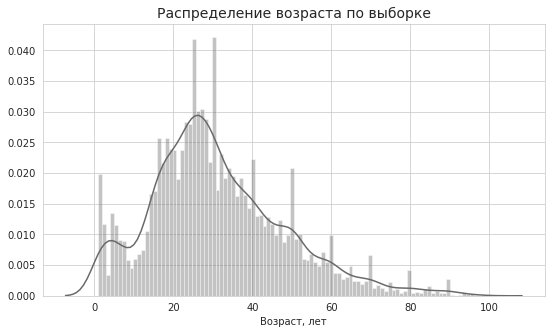

In [13]:
plt.figure(figsize=(9,5))
sns.distplot(data['real_age'], color='dimgrey', bins=100)
plt.title('Распределение возраста по выборке', size=14)
plt.xlabel('Возраст, лет');

In [14]:
data['real_age'].value_counts().head(10)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
Name: real_age, dtype: int64

I am uploading photos.

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=10,
        class_mode='raw',
        seed=43)

Found 7591 validated image filenames.


I detach features from target values, I display photos on the screen.

In [20]:
features, target = next(train_gen_flow)

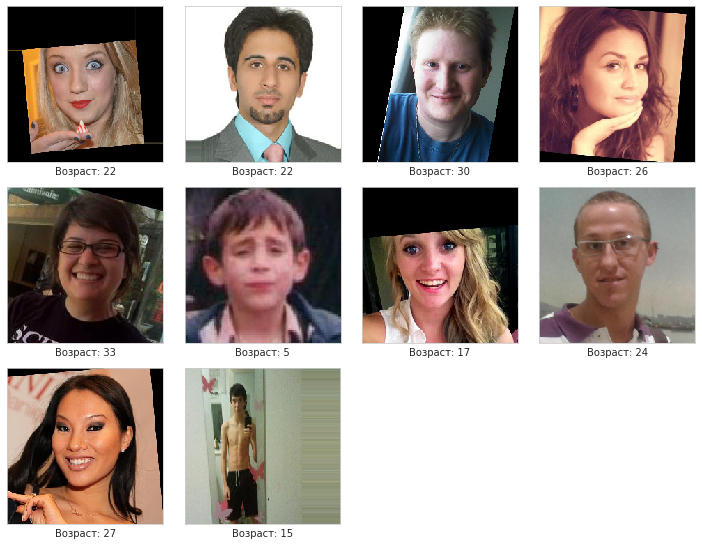

In [42]:
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f'Возраст: {target[i]}')
    plt.tight_layout()

# Conclusion

* The data consists of 7591 photographs of people aged 1 to 100 years. The data looks natural.
* The majority of people in the images are aged 20-30 years old, with peaks of 25 and 40 years old.
* There are more one-year-old babies than 10-12 year olds.
* There are outliers in the form of photographs of people whose age is round values in tens.

## Model training

(The code in this section runs in a separate GPU trainer, so it's formatted not as a cell with code, but as code in a text cell)

```python

def load_train(path):
    data = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = data,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

def load_test(path):
    data = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = data,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```

# Learning outcome

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-02-28 01:58:06.006388: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-02-28 01:58:15.714701: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 159s - loss: 212.0637 - mae: 10.7981 - val_loss: 428.4803 - val_mae: 15.5710
Epoch 2/10
178/178 - 37s - loss: 103.2356 - mae: 7.6979 - val_loss: 376.1646 - val_mae: 14.4086
Epoch 3/10
178/178 - 37s - loss: 66.3210 - mae: 6.2301 - val_loss: 445.5763 - val_mae: 15.8854
Epoch 4/10
178/178 - 37s - loss: 39.5967 - mae: 4.8214 - val_loss: 171.6518 - val_mae: 9.9762
Epoch 5/10
178/178 - 37s - loss: 28.5449 - mae: 4.1157 - val_loss: 123.8202 - val_mae: 8.2351
Epoch 6/10
178/178 - 37s - loss: 23.3018 - mae: 3.7431 - val_loss: 87.6157 - val_mae: 7.0937
Epoch 7/10
178/178 - 37s - loss: 17.8380 - mae: 3.2581 - val_loss: 94.6317 - val_mae: 7.6648
Epoch 8/10
178/178 - 37s - loss: 13.7052 - mae: 2.8466 - val_loss: 83.5784 - val_mae: 6.9890
Epoch 9/10
178/178 - 37s - loss: 13.9213 - mae: 2.8672 - val_loss: 77.7076 - val_mae: 6.6805
Epoch 10/10
178/178 - 37s - loss: 11.0738 - mae: 2.5559 - val_loss: 72.9911 - val_mae: 6.4338
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 72.9911 - mae: 6.4338
Test MAE: 6.4338



```

# Conclusion

A neural network was created with the ResNet architecture and pre-training on ImageNet. Training took place for 10 epochs at lr = 0.0005 with the Adam optimizer.

MAE on the training set was 3.089, on the validation set = 6.270. No retraining found. The result matches the condition.

## Analysis of the trained model

* Excellent, I managed to achieve the required MAE value on the validation set (MAE no more than 8).
* The model is wrong by about 6.4 years, which I consider a good result.
* It was possible to stop at the sixth epoch and reduce the training time.
* Each epoch required approximately 37 seconds - not that much.

# General Conclusion

The researching was successful.

* Given 7591 photos of people with markings, a model was created to determine the age of buyers, only about 6 years wrong.
* The age of buyers is from 0 to 100 years. The data included small outliers in slightly increased numbers of people whos age ended in 0. Most of the buyers were in their 20s and 40s.
* When creating the model, the ResNet architecture and convolutional layers pretrained on ImageNet were used. Adam optimizer, lr = 0.0005.
* It is possible to further improve the quality of the model by adjusting the training parameters, increasing the training time or augmenting the data.
* The model will successfully cope with the business task of recommending products for various age categories. A difference of 6 years in extreme cases will not significantly affect the taste preferences of customers.
* The model cannot be used to determine the age of buyers when selling alcohol. In most cases, a manual passport check will be required. Moreover, it is inevitable in accordance with the law.